# Sentiment Analysis in Natural Language Processing

In [1]:
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud


In [2]:
filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
df = pd.read_csv("/Users/sm/Documents/received/UNI PG/3Tri/Seminar/amazon_reviews.csv", sep=",")
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      4915 non-null   object 
 1   asin            4915 non-null   object 
 2   reviewerName    4914 non-null   object 
 3   helpful         4915 non-null   object 
 4   reviewText      4914 non-null   object 
 5   overall         4915 non-null   float64
 6   summary         4915 non-null   object 
 7   unixReviewTime  4915 non-null   int64  
 8   reviewTime      4915 non-null   object 
 9   day_diff        4915 non-null   int64  
 10  helpful_yes     4915 non-null   int64  
 11  total_vote      4915 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 460.9+ KB


### 1. Text Preprocessing

In [5]:
# Normalizing Case Folding
df['reviewText'] = df['reviewText'].str.lower()

# Punctuations
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '')

# Numbers
df['reviewText'] = df['reviewText'].str.replace('\d', '')

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Define the list of stopwords
sw = stopwords.words('english')

# Apply the filtering to remove stopwords from the 'reviewText' column
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(word for word in str(x).split() if word.lower() not in sw))


[nltk_data] Downloading package stopwords to /Users/sm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Rarewords

drops = pd.Series(' '.join(df['reviewText']).split()).value_counts()[-1000:]
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

In [8]:
import nltk
from textblob import TextBlob

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Apply tokenization to the 'reviewText' column
df["reviewText"] = df["reviewText"].apply(lambda x: TextBlob(x).words)
df["reviewText"].head()


[nltk_data] Downloading package punkt to /Users/sm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sm/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, sprung, higher, capacity, th...
3    [think, worked, great.had, diff, bran, 64gb, c...
4    [bought, retail, packaging, arrived, legit, or...
Name: reviewText, dtype: object

In [9]:
import nltk
from textblob import TextBlob, Word

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Ensure all entries in 'reviewText' are strings and handle NaNs
df['reviewText'] = df['reviewText'].astype(str).fillna('')

# Apply tokenization to the 'reviewText' column
df["reviewText"] = df["reviewText"].apply(lambda x: TextBlob(x).words)

# Apply lemmatization to the 'reviewText' column
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x]))

# Display the first 10 rows of the lemmatized text
df['reviewText'].head(10)


[nltk_data] Downloading package punkt to /Users/sm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sm/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/sm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                              'issues
1    'purchased 'device 'worked 'advertised 'never ...
2    'works 'expected 'sprung 'higher 'capacity 'th...
3    'think 'worked 'great.had 'diff 'bran '64gb 'c...
4    'bought 'retail 'packaging 'arrived 'legit 'or...
5    'mini 'storage 'anything 'else 'supposed 'to '...
6    'phone 'never 'skips 'beat 'file 'transfers 's...
7    'hard 'believe 'affordable 'digital 'become '3...
8    'works 'htc 'rezound 'running 'short 'space '6...
9    'galaxy 's4 'super 'fast 'card 'totally 'happy...
Name: reviewText, dtype: object

### 2. Text Visualization

In [10]:
# calculating term frequencies

tf = df["reviewText"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()

tf.columns = ["words", "tf"]
tf.head()

,words,tf
0,'issues,451.00
1,'purchased,344.00
2,'device,337.00
3,'worked,460.00
4,'advertised,111.00


In [11]:
tf.shape

(9960, 2)

In [12]:
tf["words"].nunique()

9960

In [13]:
tf["tf"].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T

count   9960.00
mean      13.43
std       78.93
min        1.00
5%         1.00
10%        1.00
25%        1.00
50%        1.00
75%        4.00
80%        6.00
90%       18.00
95%       47.05
99%      240.00
max     4634.00
Name: tf, dtype: float64

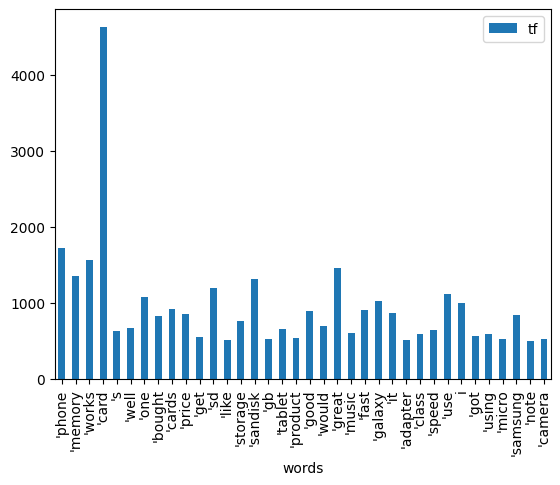

In [14]:
# Barplot

tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

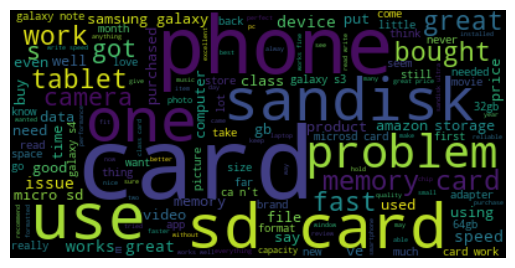

In [15]:
# Wordcloud

text = " ".join(i for i in df.reviewText)
wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

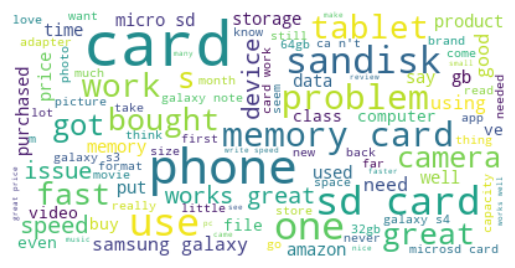

In [16]:
# generating wordcloud with brighter colour scheme
wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

### 3. Sentiment analysis


In [17]:

df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",'issues,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",'purchased 'device 'worked 'advertised 'never ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",'works 'expected 'sprung 'higher 'capacity 'th...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",'think 'worked 'great.had 'diff 'bran '64gb 'c...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",'bought 'retail 'packaging 'arrived 'legit 'or...,5.00,best deal around,1373673600,2013-07-13,513,0,0


note:
NLTK has a pre-trained sentiment analyzer called VADER (Valence Aware Dictionary and Sentiment Reasoner).

In [18]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download the VADER lexicon file
nltk.download('vader_lexicon')

# Now, you can create the SentimentIntensityAnalyzer object
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##### Calculate and print the sentiment scores for the given text using VADER (Valence Aware Dictionary and sEntiment Reasoner)
 The scores include 'neg' (negative), 'neu' (neutral), 'pos' (positive), and 'compound' (overall sentiment score)

In [19]:
sia.polarity_scores("The film was awesome")

{'neg': 0.0, 'neu': 0.423, 'pos': 0.577, 'compound': 0.6249}

In [20]:
sia.polarity_scores("I liked this music but it is not good as the other one")

{'neg': 0.207, 'neu': 0.666, 'pos': 0.127, 'compound': -0.298}

In [21]:
# for example, if we want to emphasize the reviews:
df["reviewText"].apply(lambda x: x.upper())

0                                                 'ISSUES
1       'PURCHASED 'DEVICE 'WORKED 'ADVERTISED 'NEVER ...
2       'WORKS 'EXPECTED 'SPRUNG 'HIGHER 'CAPACITY 'TH...
3       'THINK 'WORKED 'GREAT.HAD 'DIFF 'BRAN '64GB 'C...
4       'BOUGHT 'RETAIL 'PACKAGING 'ARRIVED 'LEGIT 'OR...
                              ...                        
4910    'BOUGHT 'SANDISK '16GB 'CLASS '10 'USE 'HTC 'I...
4911    'USED 'EXTENDING 'CAPABILITIES 'SAMSUNG 'GALAX...
4912    'GREAT 'CARD 'FAST 'RELIABLE 'COMES 'OPTIONAL ...
4913    'GOOD 'AMOUNT 'SPACE 'STUFF 'WANT 'DO 'FITS 'G...
4914    I 'VE 'HEARD 'BAD 'THINGS '64GB 'MICRO 'SD 'CA...
Name: reviewText, Length: 4915, dtype: object

In [22]:
# now let's calculate the scores for 10 of them
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x))


0    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2    {'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...
3    {'neg': 0.0, 'neu': 0.744, 'pos': 0.256, 'comp...
4    {'neg': 0.0, 'neu': 0.771, 'pos': 0.229, 'comp...
5    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6    {'neg': 0.097, 'neu': 0.597, 'pos': 0.306, 'co...
7    {'neg': 0.085, 'neu': 0.704, 'pos': 0.211, 'co...
8    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
9    {'neg': 0.0, 'neu': 0.481, 'pos': 0.519, 'comp...
Name: reviewText, dtype: object

In [23]:
#selecting just one component "compound" from the previous output
df["reviewText"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])


0   0.00
1   0.00
2   0.40
3   0.84
4   0.86
5   0.00
6   0.90
7   0.74
8   0.00
9   0.92
Name: reviewText, dtype: float64

In [24]:
# to perform the operation permanently on the dataframe:
df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])
df.head()


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",'issues,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",'purchased 'device 'worked 'advertised 'never ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",'works 'expected 'sprung 'higher 'capacity 'th...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",'think 'worked 'great.had 'diff 'bran '64gb 'c...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.84
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",'bought 'retail 'packaging 'arrived 'legit 'or...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86


### 4. Sentiment Modeling

In [25]:
# Feature Engineering

# Creating the Target Variable
df["reviewText"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")


0    neg
1    neg
2    pos
3    pos
4    pos
5    neg
6    pos
7    pos
8    neg
9    pos
Name: reviewText, dtype: object

In [26]:
# applying the same process to the entire dataset and adding a new variable called 'sentiment_label' to the dataset:
df["sentiment_label"] = df["reviewText"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")
df.head(10)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote,polarity_score,sentiment_label
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",'issues,4.00,Four Stars,1406073600,2014-07-23,138,0,0,0.00,neg
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]",'purchased 'device 'worked 'advertised 'never ...,5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0,0.00,neg
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",'works 'expected 'sprung 'higher 'capacity 'th...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0,0.40,pos
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",'think 'worked 'great.had 'diff 'bran '64gb 'c...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0,0.84,pos
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]",'bought 'retail 'packaging 'arrived 'legit 'or...,5.00,best deal around,1373673600,2013-07-13,513,0,0,0.86,pos
5,A2IDCSC6NVONIZ,B007WTAJTO,2Cents!,"[0, 0]",'mini 'storage 'anything 'else 'supposed 'to '...,5.00,Not a lot to really be said,1367193600,2013-04-29,588,0,0,0.00,neg
6,A26YHXZD5UFPVQ,B007WTAJTO,2K1Toaster,"[0, 0]",'phone 'never 'skips 'beat 'file 'transfers 's...,5.00,Works well,1382140800,2013-10-19,415,0,0,0.90,pos
7,A3CW0ZLUO5X2B1,B007WTAJTO,"35-year Technology Consumer ""8-tracks to 802.11""","[0, 0]",'hard 'believe 'affordable 'digital 'become '3...,5.00,32 GB for less than two sawbucks...what's not ...,1404950400,2014-10-07,62,0,0,0.74,pos
8,A2CYJO155QP33S,B007WTAJTO,4evryoung,"[1, 1]",'works 'htc 'rezound 'running 'short 'space '6...,5.00,Loads of room,1395619200,2014-03-24,259,1,1,0.00,neg
9,A2S7XG3ZC4VGOQ,B007WTAJTO,53rdcard,"[0, 0]",'galaxy 's4 'super 'fast 'card 'totally 'happy...,5.00,works great,1381449600,2013-11-10,393,0,0,0.92,pos


In [27]:
# check if we have a class imbalance problem by looking at the class distribution
df["sentiment_label"].value_counts()


sentiment_label
pos    3919
neg     996
Name: count, dtype: int64

In [28]:
# Check whether there is a difference in the given ratings between the negative and positive labels.
df.groupby("sentiment_label")["overall"].mean()


sentiment_label
neg   4.11
pos   4.71
Name: overall, dtype: float64

In [29]:
# Encoding the target variable
df["sentiment_label"] = LabelEncoder().fit_transform(df["sentiment_label"])

X = df["reviewText"]
y = df["sentiment_label"]


In [30]:
# n-gram
a = """I will demonstrate this example over a longer text for better understanding.
N-grams show combinations of words used together and are used to generate features."""

TextBlob(a).ngrams(3)


[WordList(['I', 'will', 'demonstrate']),
 WordList(['will', 'demonstrate', 'this']),
 WordList(['demonstrate', 'this', 'example']),
 WordList(['this', 'example', 'over']),
 WordList(['example', 'over', 'a']),
 WordList(['over', 'a', 'longer']),
 WordList(['a', 'longer', 'text']),
 WordList(['longer', 'text', 'for']),
 WordList(['text', 'for', 'better']),
 WordList(['for', 'better', 'understanding']),
 WordList(['better', 'understanding', 'N-grams']),
 WordList(['understanding', 'N-grams', 'show']),
 WordList(['N-grams', 'show', 'combinations']),
 WordList(['show', 'combinations', 'of']),
 WordList(['combinations', 'of', 'words']),
 WordList(['of', 'words', 'used']),
 WordList(['words', 'used', 'together']),
 WordList(['used', 'together', 'and']),
 WordList(['together', 'and', 'are']),
 WordList(['and', 'are', 'used']),
 WordList(['are', 'used', 'to']),
 WordList(['used', 'to', 'generate']),
 WordList(['to', 'generate', 'features'])]

In [31]:
# Count Vectors

from sklearn.feature_extraction.text import CountVectorizer

corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Transform the corpus into a matrix of word counts
X_c = vectorizer.fit_transform(corpus)

# Get the feature names (words) from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

# Convert the matrix to a dense array and retrieve the feature names
X_c.toarray(), feature_names


(array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
        [0, 2, 0, 1, 0, 1, 1, 0, 1],
        [1, 0, 0, 1, 1, 0, 1, 1, 1],
        [0, 1, 1, 1, 0, 0, 1, 0, 1]]),
 array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
        'this'], dtype=object))

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer with n-gram range of (2, 2)
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))

# Transform the corpus into a matrix of word counts for bi-grams
X_n = vectorizer2.fit_transform(corpus)

# Get the feature names (bi-grams) from the CountVectorizer
feature_names_ngram = vectorizer2.get_feature_names_out()

# Convert the matrix to a dense array and retrieve the feature names (bi-grams)
X_n.toarray(), feature_names_ngram


(array([[0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
        [0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]]),
 array(['and this', 'document is', 'first document', 'is the', 'is this',
        'second document', 'the first', 'the second', 'the third',
        'third one', 'this document', 'this is', 'this the'], dtype=object))

### Term Frequency-Inverse Document Frequency
 It's a numerical statistic that reflects the importance of a word in a document relative to a collection of documents (corpus).

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Define the corpus
corpus = ['This is the first document.',
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?']

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer(analyzer='word')

# Transform the corpus into a TF-IDF matrix
X_w = vectorizer.fit_transform(corpus)

# Get the feature names (words)
feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to an array
X_w_array = X_w.toarray()

feature_names, X_w_array


(array(['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third',
        'this'], dtype=object),
 array([[0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
         0.        , 0.38408524, 0.        , 0.38408524],
        [0.        , 0.6876236 , 0.        , 0.28108867, 0.        ,
         0.53864762, 0.28108867, 0.        , 0.28108867],
        [0.51184851, 0.        , 0.        , 0.26710379, 0.51184851,
         0.        , 0.26710379, 0.51184851, 0.26710379],
        [0.        , 0.46979139, 0.58028582, 0.38408524, 0.        ,
         0.        , 0.38408524, 0.        , 0.38408524]]))

In [35]:
# Initialize the TF-IDF vectorizer with n-gram range (2, 3)
vectorizer = TfidfVectorizer(ngram_range=(2, 3))

# Transform the corpus into a TF-IDF matrix
X_n = vectorizer.fit_transform(corpus)

# Get the feature names (n-grams)
feature_names = vectorizer.get_feature_names_out()

# Convert the TF-IDF matrix to an array
X_n_array = X_n.toarray()

feature_names, X_n_array

(array(['and this', 'and this is', 'document is', 'document is the',
        'first document', 'is the', 'is the first', 'is the second',
        'is the third', 'is this', 'is this the', 'second document',
        'the first', 'the first document', 'the second',
        'the second document', 'the third', 'the third one', 'third one',
        'this document', 'this document is', 'this is', 'this is the',
        'this the', 'this the first'], dtype=object),
 array([[0.        , 0.        , 0.        , 0.        , 0.37102749,
         0.30037873, 0.47060133, 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.37102749, 0.37102749, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.37102749, 0.37102749, 0.        , 0.        ],
        [0.        , 0.        , 0.34488069, 0.34488069, 0.        ,
         0.22013288, 0.        , 0.34488069, 0.        , 0.        ,
         0.        , 0.34488069, 0.        , 0.      

In [36]:
# Initialize the TF-IDF vectorizer for word-level TF-IDF
tf_idf_word_vectorizer = TfidfVectorizer()

# Transform the corpus into a TF-IDF matrix at word level
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(X)


### 5. Modeling

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Logistic Regression model training
log_model = LogisticRegression().fit(X_tf_idf_word, y)

# Calculate the mean accuracy using cross-validation
mean_accuracy = cross_val_score(log_model,
                                X_tf_idf_word,
                                y, scoring="accuracy",
                                cv=5).mean()

# Cross-validate to get predictions for precision, recall, and F1-score
y_pred = cross_val_predict(log_model, X_tf_idf_word, y, cv=5)

# Calculate precision, recall, and F1-score
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')

# Print the metrics
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Define new comments for prediction
new_comments = pd.Series(["this product is great",
                          "look at that shit very bad",
                          "it was good but I am sure that it fits me"])

# Transform the new comments into vectors using CountVectorizer
vectorizer = CountVectorizer().fit(X)
new_comments_vectorized = vectorizer.transform(new_comments)

# Predict the sentiment labels for the new comments
predictions = log_model.predict(new_comments_vectorized)

print("Predictions for new comments:", predictions)


Mean Accuracy: 0.8236012207527976
Precision: 0.8299381416551556
Recall: 0.8236012207527975
F1-Score: 0.7706001925052303
Predictions for new comments: [1 0 1]


In [58]:
# Selecting a random review from the DataFrame
random_review = pd.Series(df["reviewText"].sample(1).values)
random_review


0    'needed 'tablet 'recommend 'product 'getting '...
dtype: object

In [59]:
# Transforming the random review using the CountVectorizer fitted on the original dataset
random_review_transformed = tf_idf_word_vectorizer.transform(random_review)
# Predicting the sentiment label for the random review
log_model.predict(random_review_transformed)


array([1])